In [7]:
!pip install -U tensorflow
!pip install -U sklearn

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [8]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud
import seaborn as sns
import itertools
import json
import gensim
from sklearn.metrics import classification_report, accuracy_score


tf.config.list_physical_devices('GPU')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
PATH = "/content/gdrive/My Drive/FakeNewsDetection/"

Mounted at /content/gdrive


In [9]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

#DATASET 1

In [44]:
fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 1
true_data['label'] = 0

In [45]:
# Clean data
# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [46]:
# Combining Title and Text
true_data["text"] = true_data["title"] + " " + true_data["text"]
fake_data["text"] = fake_data["title"] + " " + fake_data["text"]

# Drop Date, title, subject 
true_data = true_data.drop(["subject", "date","title"], axis=1)
fake_data = fake_data.drop(["subject", "date", "title"], axis=1)

In [47]:
news_data = pd.concat([fake_data, true_data]).reset_index(drop = True)
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)
del fake_data, true_data

## Text articles -> Word2Vec -> LSTM

In [48]:
y = news_data["label"].values
#Converting train data to gensim format, remove punctuation and stopwords
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in news_data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del news_data

In [49]:
# Dimension of generated vectors
EMBEDDING_DIM = 10
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [50]:
len(w2v_model.wv.vocab)

122248

In [51]:
w2v_model["corona"]
w2v_model.wv.most_similar("trump")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.9826008677482605),
 ('elect', 0.9047054052352905),
 ('2016curious', 0.9037299752235413),
 ('presidency', 0.8834552764892578),
 ('becomes', 0.8706575036048889),
 ('surprise', 0.8704681396484375),
 ('outshone', 0.8675214052200317),
 ('dimished', 0.8659388422966003),
 ('demcorats', 0.8609744310379028),
 ('gla', 0.8598387241363525)]

In [52]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [53]:
# Keep all news to 1000
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [54]:
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). 
vocab_size = len(tokenizer.word_index) + 1

In [55]:
#Getting embedding vectors from word2vec
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [56]:
#Defining Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
del embedding_vectors

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [58]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=20)

Epoch 1/20
790/790 [==============================] - 35s 44ms/step - loss: 0.1581 - acc: 0.9422 - val_loss: 0.1347 - val_acc: 0.9511
Epoch 2/20
790/790 [==============================] - 35s 44ms/step - loss: 0.1161 - acc: 0.9574 - val_loss: 0.0939 - val_acc: 0.9686
Epoch 3/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0944 - acc: 0.9658 - val_loss: 0.0824 - val_acc: 0.9732
Epoch 4/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0702 - acc: 0.9753 - val_loss: 0.0889 - val_acc: 0.9685
Epoch 5/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0611 - acc: 0.9793 - val_loss: 0.0609 - val_acc: 0.9798
Epoch 6/20
790/790 [==============================] - 34s 44ms/step - loss: 0.0801 - acc: 0.9713 - val_loss: 0.0867 - val_acc: 0.9694
Epoch 7/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0991 - acc: 0.9642 - val_loss: 0.1090 - val_acc: 0.9622
Epoch 8/20
790/790 [==============================] - 35s 44ms

In [59]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype("int")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9879732739420936
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5364
           1       0.98      1.00      0.99      5861

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



([<matplotlib.axis.XTick at 0x7f36606fc7f0>,
 <a list of 20 Text major ticklabel objects>)

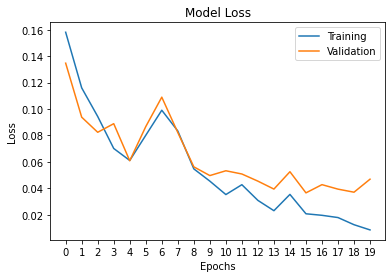

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

Confusion matrix, without normalization


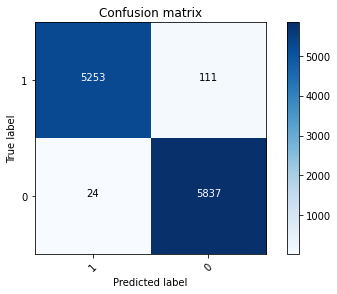

In [61]:
cm = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix(cm, classes=[1, 0])

In [27]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.legend(['Training', 'Validation'])
# plt.ylabel('Accuracy (%)')
# plt.xlabel('Epochs')
# plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

KeyError: ignored

# DATASET 2

In [28]:
# Dataset 2
X_train_2 = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_train_2 = shuffle(X_train_2)
X_train_2 = X_train_2.reset_index(drop=True)

In [29]:
X_train_2.head()

,id,title,author,text,label
0,16023,We Are The Anunnaki’s Son’s,Arnold Monteverde (noreply@blogger.com),"We are the Anunnaki’s sons, and have been give...",1
1,5461,"John D. Loudermilk, Who Wrote ‘Tobacco Road’ a...",William Grimes,"John D. Loudermilk, a country singer and proli...",0
2,8383,France and Germany Unite to Oppose President T...,Breitbart London,PARIS (AP) — France and Germany formed a un...,0
3,11697,Migrant Crime and Violence Soars in German Sta...,Virginia Hale,Authorities in two German states have expresse...,0
4,10814,EU Takes Centre Stage in ’Chaotic’ French Pres...,Nick Hallett,France’s future in the European Union was the ...,0


In [30]:
# Combining Title and Text
X_train_2["text"] = X_train_2["title"] + " " + X_train_2["text"]

# Drop id, title, author 
X_train_2 = X_train_2.drop(["id", "author","title"], axis=1)

## Text articles -> Word2Vec -> LSTM

In [32]:
y = X_train_2["label"].values
#Converting data train to gensim format 
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in X_train_2["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(str(par))
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del X_train_2

In [33]:
#Dimension of generated vectors 
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [34]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [35]:
# Keep all news to 1000
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1

In [36]:
#Getting embedding vectors from word2vec 
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [37]:
#Defining Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
del embedding_vectors

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [39]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=20)

Epoch 1/20
342/342 [==============================] - 17s 49ms/step - loss: 0.2993 - acc: 0.8778 - val_loss: 0.2409 - val_acc: 0.9041
Epoch 2/20
342/342 [==============================] - 16s 47ms/step - loss: 0.2161 - acc: 0.9118 - val_loss: 0.2166 - val_acc: 0.9122
Epoch 3/20
342/342 [==============================] - 16s 47ms/step - loss: 0.1764 - acc: 0.9312 - val_loss: 0.1476 - val_acc: 0.9476
Epoch 4/20
342/342 [==============================] - 16s 48ms/step - loss: 0.1194 - acc: 0.9565 - val_loss: 0.1496 - val_acc: 0.9502
Epoch 5/20
342/342 [==============================] - 16s 48ms/step - loss: 0.1091 - acc: 0.9603 - val_loss: 0.0978 - val_acc: 0.9632
Epoch 6/20
342/342 [==============================] - 16s 47ms/step - loss: 0.1676 - acc: 0.9340 - val_loss: 0.1449 - val_acc: 0.9440
Epoch 7/20
342/342 [==============================] - 16s 47ms/step - loss: 0.0972 - acc: 0.9657 - val_loss: 0.0976 - val_acc: 0.9690
Epoch 8/20
342/342 [==============================] - 16s 47ms

In [40]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype("int")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9826923076923076
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2606
           1       0.98      0.98      0.98      2594

    accuracy                           0.98      5200
   macro avg       0.98      0.98      0.98      5200
weighted avg       0.98      0.98      0.98      5200



([<matplotlib.axis.XTick at 0x7f3660a19c18>,
 <a list of 20 Text major ticklabel objects>)

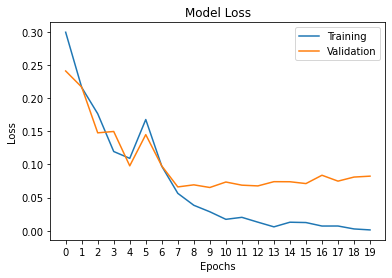

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])


In [42]:
def confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


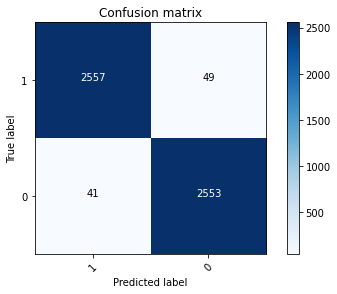

In [43]:
cm = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix(cm, classes=[1, 0])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
